# Индивиуальное задание

## Этап  № 4. Исследование моделей размещения пользователей и распространения сигнала

_Выполнил_ студент 2 курса<br>
учебной группы НММ-02-22<br>
Мулин Иван

### Цели
Построить согласно описанному ниже алгоритму имитационную модель, позволяющую рассчитать вероятность блокировки линии прямой видимости, и сравнить полученную характеристику с результатами математической модели.

### Задача

1. В квадратной области со стороной $А$ согласно точечному Пуассоновскому процессу с плотностью $q$ разместить объекты (окружности с фиксированным радиусом $r$), которые могут заблокировать линию прямой видимости между двумя точками, размещенными на расстоянии x друг от друга внутри обозначенной области. Проверить блокирует ли хотя бы один объект линию прямой видимости.
2. Количество блокирующих объектов определяется согласно распределению Пуассона с параметром $qA^2$, а объекты вбрасываются независимо друг от друга. При этом центры блокирующих объектов должны быть распределены равномерно внутри рассматриваемой области.
3. На основе описанного выше алгоритма получить 1000 реализаций факта блокировки линии прямой видимости и рассчитать вероятность блокировки линии прямой видимости в поле блокирующих объектов. Полученный результат сравнить с результатами математической модели

### Ход работы

Подключаем нужные и ненужные библиотеки. После этого вводим константы, данные по условию.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from numpy.linalg import norm
from numpy import arcsin, arccos, dot, cross, pi

In [2]:
SquareWidth = 10
PoissonParameter = 0.3
Radius = 0.5
TRDistance = 3
Points = np.array

angles = np.linspace(0, 2 * pi, 80)

Далее опишем функции, необходимые для построения модели.

In [3]:
def DrawCircle(x0, y0, r, hue="#eb3437"):
    """
    Draws a circle on a plot.
    """
    global angles
    xs = x0 + r*np.cos(angles)
    ys = y0 + r*np.sin(angles)
    plt.plot(x0, y0, color = hue, marker=".")
    plt.plot(xs, ys, color = hue)
    plt.fill(xs, ys, color = hue+"80") # 50% transparency

def DrawRectangle(Rectangle, hue="#ebcc34"):
    """
    Draws a rectangle.
    """
    xs, ys = Rectangle[0], Rectangle[1]
    plt.plot(xs, ys, color=hue)
    plt.fill(xs, ys, color=hue+"80")

In [4]:
def PoissonProcessInitializer(lam, area):
    """
    Initializes Poisson process.
    """
    amount = np.random.poisson(lam * area**2)
    x = np.random.uniform(0, area, size=amount)
    y = np.random.uniform(0, area, size=amount)
    return x, y

In [5]:
def sign(x):
    " A mathematical sgn(x). "
    if x == 0:
        return 0
    return x/abs(x)

In [6]:
def GetRectangleCoords(p1x, p1y, p2x, p2y):
    """
    Calculates rectangle ABCD's coordinates.
    """
    global Radius
    distance = norm([p2x-p1x, p2y-p1y])
    W = pi/2 - sign( arcsin((p2y-p1y)/distance) ) * arccos((p2x-p1x)/distance)
    RC, RS = Radius*np.cos(W), Radius*np.sin(W)

    Ax, Ay = p1x - RC, p1y + RS
    Bx, By = p1x + RC, p1y - RS
    Cx, Cy = p2x + RC, p2y - RS
    Dx, Dy = p2x - RC, p2y + RS

    return [Ax, Bx, Cx, Dx, Ax], [Ay, By, Cy, Dy, Ay]

In [7]:
def CalDistance(L, P):
    """
    Calculates distance between line Ax+By+C=0 and point P=(x0 y0)
    (L=(A B C).)
    """
    Q = L[:-1]
    R = np.append( np.transpose(P), 1)
    return abs( np.matmul(L, R) ) / norm(Q)

In [8]:
def GetLine(x1, y1, x2, y2):
    """
    Calculates vector (A B C) for a line Ax+By+C=0.
    """
    det = x1*y2 - x2*y1
    if det != 0: # y=kx+s, s!=0
        A = (y1-y2) / det
        B = (x2-x1) / det
        return np.array([A, B, 1])
    
    if x1**2 + y1**2 == 0 or x1==0 or y1==0: # if x1=y1, that is not a line!
        return np.array([0, 1, 0])
        
    # ...then it is y=kx, k!=0
    B = -1
    A = y1/x1
    return np.array([A, B, 0])

In [9]:
def CountCollisions(Rect, BlockerCentres, debugging=False, distance=TRDistance):
    """
    Will count how many collisions happened.
    If debugging=True, it will draw blockators with proper colors and say where it is.
    """
    global Radius, TRDistance
    collisions = 0
    D = 2*Radius
    
    P1 = [ (Rect[0][0]+Rect[0][1])*0.5, (Rect[1][0]+Rect[1][1])*0.5 ]
    P2 = [ (Rect[0][2]+Rect[0][3])*0.5, (Rect[1][2]+Rect[1][3])*0.5 ]
    if distance != TRDistance:
        distance = norm([P2[0]-P1[0], P2[1]-P1[1]]) # it could well be inaccurate!!!
    
    Midline = GetLine(P1[0], P1[1], P2[0], P2[1])
    Sides = GetLine(P1[0], P1[1], Rect[0][0], Rect[1][0]), \
            GetLine(P2[0], P2[1], Rect[0][3], Rect[1][3])
    
    for p in BlockerCentres:
        t = CalDistance(Midline, p)
        l1, l2 = CalDistance(Sides[0], p), CalDistance(Sides[1], p)
        lmin = min(l1, l2)
        
        L = l1+l2
        L -= (L % 0.0000001) 
        # I added L because 1.4+1.6=3.0000000000000001 messes all up
        
        if L>distance and Radius>lmin:
            r = np.sqrt( Radius**2 - lmin**2 )
            
            if t<r+Radius:
                collisions += 1
                if debugging:
                    print(f"Collision type 1 at {p}")
                    DrawCircle(p[0], p[1], Radius, "#eb3446")
            
            else: # non-colliding blockator
                if debugging:
                    DrawCircle(p[0], p[1], Radius, "#424ef5")
        elif t<D and L<=distance:
                collisions += 1
                if debugging:
                    print(f"Collision type 2 at {p}")
                    DrawCircle(p[0], p[1], Radius, "#eb3446")
        else: # non-colliding blockator
            if debugging:
                DrawCircle(p[0], p[1], Radius, "#424ef5")
    return collisions

In [10]:
def DrawLineOfSight(p1x, p1y, p2x, p2y, hue1="#34eb4f", hue2="#ebcc34"):
    """
    Draws a line of sight.
    """
    Rectangle = GetRectangleCoords(p1x, p1y, p2x, p2y)
    DrawRectangle(Rectangle, hue2)
    plt.plot((p1x, p2x), (p1y, p2y), marker=".", color=hue1, linestyle="dashed")
    return Rectangle

### Тестовая модель
Участок кода ниже предназначен для проверки работы написанных функций.

Collision type 1 at (4.3, 1.6)
Line of sight is blocked 1 times


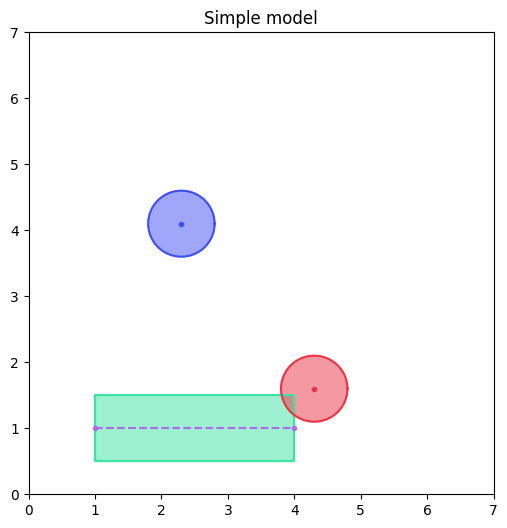

In [11]:
W = 0.3
p1x, p1y = 1, 1
p2x, p2y = 4, 1
# p2x, p2y = p1x + TRDistance*np.cos(W), p1y + TRDistance*np.sin(W)

Rectangle = GetRectangleCoords(p1x, p1y, p2x, p2y)

plt.figure(dpi=100, figsize=(6, 6))
plt.title("Simple model")

Rectangle = DrawLineOfSight(p1x, p1y, p2x, p2y, "#ae6be8", "#3de3a3")

Ab = [[p1x, p1y], [p2x, p2y]]
BC = [(4.3, 1.6), (2.3, 4.1)]
print("Line of sight is blocked %i times" % CountCollisions(Rectangle, BC, 1, 1))

plt.xlim(0, 7)
plt.ylim(0, 7)
plt.show()

### Полноценная единичная симуляция
Данный фрагмент осуществляет отрисовку единичной симуляции:

Collision type 2 at (1.6549575303103659, 2.442400419272577)
Collision type 2 at (3.493133566137814, 3.1198661666481575)
Line of sight is blocked 2 times


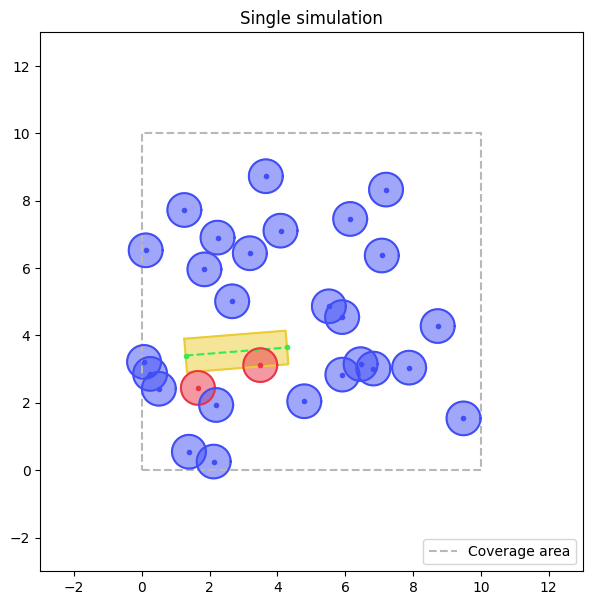

In [12]:
x, y = PoissonProcessInitializer(PoissonParameter, SquareWidth)

p1x, p1y = np.random.uniform(0, SquareWidth), np.random.uniform(0, SquareWidth)
W = np.random.uniform(0, 2*np.pi)
p2x, p2y = p1x + TRDistance*np.cos(W), p1y + TRDistance*np.sin(W)
CoverageArea = ((0, SquareWidth, SquareWidth, 0, 0), (0, 0, SquareWidth, SquareWidth, 0))

plt.figure(dpi=100, figsize=(7, 7))
plt.title("Single simulation")

plt.plot(CoverageArea[0], CoverageArea[1], linestyle="dashed", color="#b8b8b8", label="Coverage area")
Rectangle = DrawLineOfSight(p1x, p1y, p2x, p2y)

BC = zip(x, y)
collisions = CountCollisions(Rectangle, BC, 1)
if collisions:
    print("Line of sight is blocked %i times" % collisions)
else:
    print("Line of sight is not blocked")


plt.xlim(-TRDistance, SquareWidth+TRDistance)
plt.ylim(-TRDistance, SquareWidth+TRDistance)
plt.legend(loc="lower right")
plt.show()

### Решение задачи
Участок кода ниже вычисляет приблизительную вероятность блокировки сигнала.

In [13]:
N = 1000
S = 0

for i in range(N):
    x, y = PoissonProcessInitializer(PoissonParameter, SquareWidth)

    p1x, p1y = np.random.uniform(0, SquareWidth), np.random.uniform(0, SquareWidth)
    W = np.random.uniform(0, 2*np.pi)
    p2x, p2y = p1x + TRDistance*np.cos(W), p1y + TRDistance*np.sin(W)
    Rectangle = GetRectangleCoords(p1x, p1y, p2x, p2y)
    
    Ab = [[p1x, p1y], [p2x, p2y]]
    BC = zip(x, y)
    
    if (CountCollisions(Rectangle, BC, 0)): S += 1
print("Probability of blockade is approximately %.3f" % (S/N))

Probability of blockade is approximately 0.796


Как видно, вероятность блокировки равна примерно 80%. Математическое значение вероятности блокировки, которое ожидается получить (при этом блокирование считается, в случае если блокатор находится в участке прямой видимости), вычисляется с помощью участка кода ниже:

In [14]:
# For the complexity I've reached it gets just lower bound
Sb = 2*Radius*TRDistance
MeanNOfBlockators = PoissonParameter * Sb
MathProbability = 1 - np.exp(-MeanNOfBlockators)

print("Math probability is %.3f" % MathProbability)

Math probability is 0.593


### Вывод
В ходе работы был описан функционал для симулирования работы сети 5G в пределах зоны работы радиостанциии на плоскости. Посредством написанных инструментов была вычислена вероятность блокировки линии прямой видимости.